## Riksarkivet SBL  - Wikidata ett försök att synka dom
version 0.43

WD egenskap [Property:P3217](https://www.wikidata.org/wiki/Property:P3217) 
* den här [notebooken](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb)   
  * SBL personartiklar som saknar [sv:Wikipedia artikel](https://w.wiki/c5f) < 150
* [SBL vs SKBL female articles](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)  

SBL har idag
* personartiklar
* släktartiklar
  * en person i en släktartikel kan ha en sida som bara pekar till släktartikeln (med text ej länk)

Det saknas idag från Riksarkivet ett API så nedanstående är ett försök att webscrapa deras data och sedan försöka hitta en struktur. 

Målsättningen är att ha personerna som har en SBL personartikel representerade i Wikidata. Kul vore att även ha släktartiklarna kopplade till Wikidata... är inte säkert hur bra strukturen är för släkter/ätter/familjer i WD och sedan behövs det matchas en hel del. En person kan även omnämnas i en släktartikel och bör då i Wikidata ha "beskriven av källa" kopplad till dessa artiklar (exempel Gunnar Mossing [Q5994570#P1343](https://www.wikidata.org/wiki/Q5994570#P1343) som finns i artikel SBL ["Morssing, släkt"](https://sok.riksarkivet.se/sbl/Presentation.aspx?id=9512)) vilket är ett mycket stort jobb om Riksarkivet inte går över till att leverera [länkade data](https://sv.wikipedia.org/wiki/L%C3%A4nkade_data)...     

**Mina gissningar** 
1. sida med född/död är en person
2. sida med titel släkt är en släktartikel
3. sida med född/död men för kort kan vara en referens till en släktartikel
4. släkt artikel kan ha "[ätt](https://sok.riksarkivet.se/sbl/Search.aspx?t=0)" i titeln men det kan visst även person artiklar ha
5. ....

### jmf SKBL med SBL 
med ett mera komplett Wikidata kan vi nu jämföra [Svenskt Kvinnobiografiskt lexikon - SKBL](https://www.skbl.se/sv/om-skbl) med [Riksarkivet](https://sok.riksarkivet.se/sbl/OmSBL.aspx) då det gäller urval av kvinnor, antal kvinnor, hur dom levererar, API vs. inte API, skillnaden att ha enbart svenska artiklar som SBL med att även ha [engelska artiklar som SKBL](https://www.skbl.se/en/about-skbl) 

* [Notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)

# Webscrape 
1. vi gissar id min 4000 och max 40000


In [1]:
from datetime import datetime
now = datetime.now()
print("Last run: ", now)

Last run:  2020-09-17 06:49:48.910460


In [2]:
import urllib3, json
import pandas as pd   
from bs4 import BeautifulSoup
import sys
import pprint
http = urllib3.PoolManager()

from tqdm.notebook import trange  
listNewItems =[]

for SBLnr in trange(4000,40000): #gissar min 4000 max 40000
    url = "https://sok.riksarkivet.se/sbl/Presentation.aspx?id=" + str(SBLnr)
    r = http.request('GET', url) 
    if len(r.data) > 11020:
        new_item = dict()
        #print(SBLnr)
        new_item['SBLnr'] = SBLnr
        new_item['SBLlength'] = len(r.data)
        soup = BeautifulSoup(r.data, "html.parser")  
        
        try:
            titel = soup.findAll("span", {"id": "ctl00_MainContent_lblTitle"})[0].get_text()
            new_item['titel'] = titel
            #print ("\t",titel)
        except:
            pass
        try:
            Fodd = soup.findAll("span", {"id": "ctl00_MainContent_lblFodelse"})[0].get_text()
            #print ("\t",Fodd)
            new_item['Fodd'] = Fodd
        except:
            pass
        try:
            Dod = soup.findAll("span", {"id": "ctl00_MainContent_lblDod"})[0].get_text()
            #print ("\t",Dod)
            new_item['Dod'] = Dod
        except:
            pass
        try:
            band = soup.findAll("span", {"id": "ctl00_MainContent_lblBandSida"})[0].get_text()
            #print ("\t",band)
            new_item['Band'] = band
            try:
#                year = band.get_text().split("(")[1].split(")")
                year = band.split("(")[1].split(")")[0]
                #print ("\t\tYear",year)
                new_item['Year'] = year
            except:
                pass
        except:
            pass
            
        listNewItems.append(new_item)
print (len(listNewItems) ," antal poster")
        



10127  antal poster


In [3]:
import csv
if len(listNewItems) > 0:
    keys = listNewItems[0].keys()
    with open("SBL_newfile.csv", "w", newline='') as SBLfile:
        dict_writer = csv.DictWriter(SBLfile, keys)
        dict_writer.writeheader()
        dict_writer.writerows(listNewItems)

    dfSBLcsv = pd.read_csv("SBL_newfile.csv", sep=",")   
    
else:
    print ("Ingen fil skapas inga nya poster") 

In [4]:
pd.set_option("display.max.rows", None) 

In [5]:
dfSBLcsv.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      10127 non-null  int64 
 1   SBLlength  10127 non-null  int64 
 2   titel      10127 non-null  object
 3   Fodd       7081 non-null   object
 4   Dod        7563 non-null   object
 5   Band       10127 non-null  object
 6   Year       10111 non-null  object
dtypes: int64(2), object(5)
memory usage: 553.9+ KB


## Wikidata hämtar alla med P3217 satt 
dvs. även släkt kopplingar

In [6]:
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

querySKBL = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?sblid WHERE {
?item wdt:P3217 ?sblid
}"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDSBLtot = get_sparql_dataframe(endpoint_url, querySKBL)


In [7]:
WDSBLtot.sort_index(inplace=True)  

In [8]:
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7670 entries, 0 to 7669
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wid     7670 non-null   object
 1   sblid   7670 non-null   object
dtypes: object(2)
memory usage: 120.0+ KB


In [9]:
%matplotlib inline    
import matplotlib.pyplot as plt   
plotSBLYear = dfSBLcsv["Year"].value_counts()


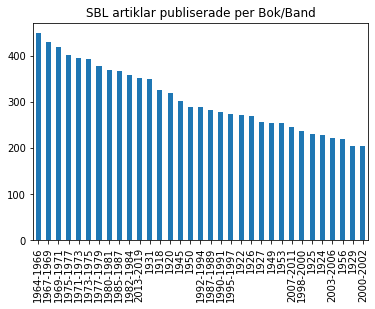

In [10]:
plotSBLYear.plot( kind = 'bar') 
plt.title("SBL artiklar publiserade per Bok/Band")
plt.show()

In [11]:
dfSBLcsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      10127 non-null  int64 
 1   SBLlength  10127 non-null  int64 
 2   titel      10127 non-null  object
 3   Fodd       7081 non-null   object
 4   Dod        7563 non-null   object
 5   Band       10127 non-null  object
 6   Year       10111 non-null  object
dtypes: int64(2), object(5)
memory usage: 553.9+ KB


In [12]:
dfSBLcsv["url"] = "https://sok.riksarkivet.se/sbl/Presentation.aspx?id=" + str(dfSBLcsv["SBLnr"])

In [13]:
#dfFamily = dfSBLAuthorcsv.dropna()  
dfPerson = dfSBLcsv.dropna(subset = ['Fodd', 'Dod'])

In [14]:
dfPerson.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7074 entries, 1 to 10125
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      7074 non-null   int64 
 1   SBLlength  7074 non-null   int64 
 2   titel      7074 non-null   object
 3   Fodd       7074 non-null   object
 4   Dod        7074 non-null   object
 5   Band       7074 non-null   object
 6   Year       7073 non-null   object
 7   url        7074 non-null   object
dtypes: int64(2), object(6)
memory usage: 497.4+ KB


In [15]:
dfFamily = dfSBLcsv[dfSBLcsv.isnull().any(1)]

In [16]:
dfFamily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054 entries, 0 to 10126
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      3054 non-null   int64 
 1   SBLlength  3054 non-null   int64 
 2   titel      3054 non-null   object
 3   Fodd       8 non-null      object
 4   Dod        490 non-null    object
 5   Band       3054 non-null   object
 6   Year       3038 non-null   object
 7   url        3054 non-null   object
dtypes: int64(2), object(6)
memory usage: 214.7+ KB


In [68]:
#dfFamily

In [18]:
dfFamilySlakt = dfFamily[dfFamily.titel.str.contains("släkt")]
#dfFamilySlakt

In [19]:
dictFamily = dfFamilySlakt.to_dict()

In [20]:
dfFamily.titel.str.contains("släkt").sum()

1722

In [21]:
dfFamily.titel.str.contains("ätten").sum()

37

In [22]:
dfFamily.titel.str.contains("Släkt").sum()

1

In [23]:
dfFamily.Dod.str.contains("senas").sum()

22

In [69]:
#dfFamily[dfFamily.Dod.str.contains("senas", na=False)]

In [25]:
dfFamily[dfFamily.Fodd.str.contains("", na=False)]

,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year,url
165,5671,19032,A Adele L Almati-Rundberg,"Född:1861-02-23 – USA, Amerikas Förenta Stater...",NaN,"Band 01 (1918), sida 417.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
223,5735,26859,Johan Mathias Ambrosius,Född:1843-02-08,NaN,"Band 01 (1918), sida 576.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
459,6061,50431,Peter A Smalze,"Född:1610 – Örebro församling, Örebro län (tro...",NaN,"Band 32 (2003-2006), sida 553.",2003-2006,https://sok.riksarkivet.se/sbl/Presentation.as...
6728,15777,19830,G. Adrian Dahl,"Född:1864-03-05 – Stockholms stad, Stockholms län",NaN,"Band 09 (1931), sida 543.",1931,https://sok.riksarkivet.se/sbl/Presentation.as...
6735,15784,32709,Magnus E. Dahlander,"Född:1862-08-02 – Säters stadsförsamling, Dala...",NaN,"Band 09 (1931), sida 592.",1931,https://sok.riksarkivet.se/sbl/Presentation.as...
6736,15785,61808,Robert Dahlander,"Född:1870-06-09 – Göteborgs stad, Västra Götal...",NaN,"Band 09 (1931), sida 596.",1931,https://sok.riksarkivet.se/sbl/Presentation.as...
7673,16990,31341,Carl Axel Brolén,"Född:1845-06-14 – Sala stadsförsamling, Västma...",NaN,"Band 06 (1926), sida 334.",1926,https://sok.riksarkivet.se/sbl/Presentation.as...
9826,34648,51924,Carl Olof (Olle) Sturén,"Född:1919-02-20 – Katarina församling, Stockho...",Död:2003-05-16 – Spanien,"Band , sida .",NaN,https://sok.riksarkivet.se/sbl/Presentation.as...


In [26]:
#Check diff WDSBLtot and dfSBLcsv 
WDSBLtot.duplicated(subset=['wid']).sum()

1

In [27]:
dfSBLcsv.duplicated(subset=['SBLnr']).sum()

0

In [28]:
WDSBLtot.duplicated(subset=['sblid']).sum()

12

In [29]:
WDSBLtot = WDSBLtot.rename(columns={'sblid':'SBLnr'})
WDSBLtot['SBLnr']= WDSBLtot['SBLnr'].astype(str).astype(int)
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7670 entries, 0 to 7669
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wid     7670 non-null   object
 1   SBLnr   7670 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.0+ KB


In [30]:
dfmerge = pd.merge(WDSBLtot, dfSBLcsv,how='outer', on='SBLnr',indicator=True)

In [31]:
dfmerge["_merge"].value_counts()

both          7669
right_only    2470
left_only        1
Name: _merge, dtype: int64

In [32]:
#dfmerge

In [33]:
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','SBL_only')


In [34]:
WDSBLonly = dfmerge[dfmerge["_merge"] == "SBL_only"].copy()   
dfmerge["_merge"].value_counts()

both        7669
SBL_only    2470
WD_only        1
Name: _merge, dtype: int64

In [35]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2470 entries, 7670 to 10139
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wid        0 non-null      object 
 1   SBLnr      2470 non-null   int64  
 2   SBLlength  2470 non-null   float64
 3   titel      2470 non-null   object 
 4   Fodd       2 non-null      object 
 5   Dod        3 non-null      object 
 6   Band       2470 non-null   object 
 7   Year       2455 non-null   object 
 8   url        2470 non-null   object 
 9   _merge     2470 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 212.3+ KB


In [36]:
WDSBLonly.titel.str.contains("släkt").sum() 


1632

In [37]:
WDSBLonly[WDSBLonly.titel.str.contains("ätt")]

,wid,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year,url,_merge
7846,NaN,7249,25607.0,"Pfalziska ätten,",NaN,NaN,"Band 29 (1995-1997), sida 283.",1995-1997,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8011,NaN,9008,11045.0,"(Malsta-ätten), Kettil Johansson",NaN,NaN,"Band 25 (1985-1987), sida 41.",1985-1987,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8012,NaN,9009,11035.0,"(Malsta-ätten), Thomas Jonsson",NaN,NaN,"Band 25 (1985-1987), sida 40.",1985-1987,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8291,NaN,11237,39684.0,"Lepasätten, släkt",NaN,NaN,"Band 22 (1977-1979), sida 579.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8292,NaN,11238,11039.0,"(Lepasätten), Björn Clausson",NaN,NaN,"Band 22 (1977-1979), sida 579.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8293,NaN,11239,11039.0,"(Lepasätten), Hans Björnsson",NaN,NaN,"Band 22 (1977-1979), sida 580.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8308,NaN,11377,11143.0,"(Likvidssönernas ätt), Anund Hemmingsson",NaN,NaN,"Band 22 (1977-1979), sida 768.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8309,NaN,11378,11133.0,"(Likvidssönernas ätt), Hemming Larsson",NaN,NaN,"Band 22 (1977-1979), sida 768.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8310,NaN,11379,11168.0,"(Likvidssönernas ätt), Likvid Germundsson",NaN,NaN,"Band 22 (1977-1979), sida 768.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8311,NaN,11380,11138.0,"(Likvidssönernas ätt), Peter Likvidsson",NaN,NaN,"Band 22 (1977-1979), sida 767.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only


In [38]:
#Inte släkt 
WDmissingPerson = WDSBLonly[~WDSBLonly.titel.str.contains("släkt")]

In [39]:
WDmissingPerson.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838 entries, 7672 to 10139
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wid        0 non-null      object 
 1   SBLnr      838 non-null    int64  
 2   SBLlength  838 non-null    float64
 3   titel      838 non-null    object 
 4   Fodd       2 non-null      object 
 5   Dod        3 non-null      object 
 6   Band       838 non-null    object 
 7   Year       823 non-null    object 
 8   url        838 non-null    object 
 9   _merge     838 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 72.0+ KB


In [40]:
WDmissingPerson["Year"].value_counts()

2013-2019    140
2007-2011     65
1953          52
1985-1987     43
2003-2006     36
1931          33
1950          33
1992-1994     31
1977-1979     28
1982-1984     26
1980-1981     25
1998-2000     25
1964-1966     23
1945          21
1987-1989     21
1973-1975     21
1929          20
1969-1971     20
2000-2002     20
1956          20
1967-1969     19
1949          16
1990-1991     11
1971-1973     11
1920          10
1975-1977     10
1926           9
1995-1997      8
1925           7
1918           6
1927           5
1924           4
1922           4
Name: Year, dtype: int64

In [41]:
print("Min, Max SBLlength: ", WDmissingPerson.SBLlength.min(), WDmissingPerson.SBLlength.max())

Min, Max SBLlength:  11021.0 82050.0


In [42]:
# sorterar artiklarna efter sidstorlek för att kanske hitta någon vi missat  
# wid är Wikidata objekt , NaN är att det saknas  
# SBLnr är id i SBL
# SBLlength är sidans storlek hos SBL 
# Fodd, Dod... är det jag hittade i WEBsidan, NaN innebär saknas

#WDmissingPerson.sort_values(by='SBLlength', ascending=False, na_position='first')

,wid,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year,url,_merge
9063,NaN,15413,82050.0,"Erikska ätten,",NaN,NaN,"Band 14 (1953), sida 354.",1953,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8834,NaN,14301,57654.0,"Folkungaätten,",NaN,NaN,"Band 16 (1964-1966), sida 260.",1964-1966,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
10114,NaN,34848,51985.0,"Swedlund,",NaN,NaN,"Band 34 (2013-2019), sida 537.",2013-2019,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
7950,NaN,8295,44685.0,"Nordin, af, Gustaf",NaN,NaN,"Band 27 (1990-1991), sida 367.",1990-1991,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
10108,NaN,34831,37608.0,"Svedelius,",NaN,NaN,"Band 34 (2013-2019), sida 481.",2013-2019,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8897,NaN,14612,31760.0,"Färla, ätter",NaN,NaN,"Band 16 (1964-1966), sida 686.",1964-1966,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
9190,NaN,16041,30767.0,"Elofssönernas ätt,",NaN,NaN,"Band 13 (1950), sida 407.",1950,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8742,NaN,13783,28865.0,"Holstein-Gottorpska ätten,",NaN,NaN,"Band 19 (1971-1973), sida 323.",1971-1973,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
9937,NaN,34514,28770.0,"Erik, sagokungar,",NaN,NaN,"Band 14 (1953), sida 242.",1953,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8809,NaN,14142,28471.0,"Finstaätten,",NaN,NaN,"Band 16 (1964-1966), sida 51.",1964-1966,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only


In [43]:
WDmissingPerson["Year"].value_counts()

2013-2019    140
2007-2011     65
1953          52
1985-1987     43
2003-2006     36
1931          33
1950          33
1992-1994     31
1977-1979     28
1982-1984     26
1980-1981     25
1998-2000     25
1964-1966     23
1945          21
1987-1989     21
1973-1975     21
1929          20
1969-1971     20
2000-2002     20
1956          20
1967-1969     19
1949          16
1990-1991     11
1971-1973     11
1920          10
1975-1977     10
1926           9
1995-1997      8
1925           7
1918           6
1927           5
1924           4
1922           4
Name: Year, dtype: int64

In [44]:
print("End run: ", datetime.now())

End run:  2020-09-17 07:52:53.531384


In [47]:
#Släkt 
#WDSlakt = WDSBLonly[~WDSBLonly.titel.str.contains("släkt")].copy

In [65]:
WDSlakt = WDSBLonly[WDSBLonly.titel.str.contains("släkt")]

In [66]:
WDSlakt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1632 entries, 7670 to 10097
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wid        0 non-null      object 
 1   SBLnr      1632 non-null   int64  
 2   SBLlength  1632 non-null   float64
 3   titel      1632 non-null   object 
 4   Fodd       0 non-null      object 
 5   Dod        0 non-null      object 
 6   Band       1632 non-null   object 
 7   Year       1632 non-null   object 
 8   url        1632 non-null   object 
 9   _merge     1632 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 140.2+ KB


In [67]:
#Need a workaround as to_csv dont work ?!?!?
for  index,row in WDSlakt.iterrows():
#    print(row["SBLnr"],row["titel"],row["Year"],row["url"])    
    print(row["SBLnr"],"|",row["titel"],"|",row["Year"])

5490 | Abelin, släkt | 1918
5496 | Abrahamson, släkt | 1918
5504 | Achrelius, släkt | 1918
5511 | Acrelius, släkt | 1918
5516 | Adelborg, släkt | 1918
5521 | Adelcrantz, släkt | 1918
5524 | Adelheim, släkt | 1918
5527 | Adelsköld, släkt | 1918
5530 | Adelswärd, släkt | 1918
5541 | Adlerberg, släkt | 1918
5543 | Adlerbeth, släkt | 1918
5546 | Adlercreutz, släkt | 1918
5553 | Adlerfelt, släkt | 1918
5558 | Adlersparre, släkt | 1918
5566 | Adlerstedt, släkt | 1918
5571 | Adlerz, släkt | 1918
5577 | Afzelius, släkt | 1918
5589 | Agardh, släkt | 1918
5596 | Agrell (Agrelius), släkt | 1918
5597 | Agrell, släkt | 1918
5598 | Agrell, släkt | 1918
5616 | Ahlman, släkt | 1918
5620 | Ahlqvist, släkt | 1918
5628 | Ahnfelt, släkt | 1918
5637 | Aken, von, släkt | 1918
5643 | Alanus, släkt | 1918
5652 | Alexanderson, släkt | 1918
5659 | Algotssönerna, släkt | 1918
5663 | Alin, släkt | 1918
5672 | Almén, släkt | 1918
5676 | Almfelt, släkt | 1918
5679 | Almgren, släkt | 1918
5686 | Almlöf, släkt | 1918

11604 | Klingenstierna, släkter | 1975-1977
11610 | Klingspor, släkter | 1975-1977
11620 | Klingstedt, släkter | 1975-1977
11625 | Klint, släkter | 1975-1977
11627 | Klint, af (Klint), släkter | 1975-1977
11634 | Klintberg, Klintberg af, släkter | 1975-1977
11640 | Klinteberg, af, släkt | 1975-1977
11643 | Klockhoff, släkter | 1975-1977
11647 | Knape, släkter | 1975-1977
11652 | Kniberg, släkter | 1975-1977
11653 | Knorring; Knorring, von, släkter | 1975-1977
11669 | Knös, släkter | 1975-1977
11680 | Koch; Koch, von, släkter | 1975-1977
11692 | Kock, släkter | 1975-1977
11693 | Kock, släkter | 1975-1977
11701 | Kockum, släkter | 1975-1977
11705 | Kôersner, släkter | 1975-1977
11718 | Kolthoff, släkter | 1975-1977
11722 | Konow, von, släkter | 1975-1977
11727 | Koschell, släkter | 1975-1977
11728 | Koskull, släkter | 1975-1977
11738 | Kræmer, von, släkter | 1975-1977
11755 | Kreuger, släkter | 1975-1977
11765 | Kristensson, släkter | 1975-1977
11778 | Krok, släkter | 1975-1977
11786 | K

14478 | Fries, släkt (Elias-släkten) | 1964-1966
14479 | Fries, släkt från Närke | 1964-1966
14480 | Fries, släkt från Skåne | 1964-1966
14489 | Friesen, von, släkt | 1964-1966
14493 | Friesendorff, von, släkt | 1964-1966
14498 | Frigelius, släkt | 1964-1966
14500 | Friis, släkt | 1964-1966
14502 | Frille, släkt | 1964-1966
14505 | Frisell, släkt | 1964-1966
14508 | Frisendahl, släkt | 1964-1966
14514 | Frosterus, släkt | 1964-1966
14517 | Frumerie, släkt | 1964-1966
14520 | Frykholm, släkt | 1964-1966
14526 | Fryxell, släkt | 1964-1966
14537 | Fröberg, släkter | 1964-1966
14538 | Fröberg, släkt från Stockholm | 1964-1966
14539 | Fröberg, släkt från Södermanland | 1964-1966
14550 | Fröding, släkt från Göteborg | 1964-1966
14551 | Fröding, släkt från Värmland | 1964-1966
14560 | Frölich, släkt, adlig | 1964-1966
14561 | Frölich, släkt från Stockholm | 1964-1966
14571 | Fröman, släkter | 1964-1966
14576 | Funch, släkt | 1964-1966
14579 | Funck, släkt | 1964-1966
14589 | Funcke, von Funck

17759 | Düring, von, släkt | 1945
17764 | Dyrssen, släkt | 1945
17773 | Döbeln, von, släkt | 1945
17779 | Dönhoff (Doenhoff, Denhoff), släkt | 1945
17815 | Blomstrand, släkt | 1925
17821 | Blume, släkt | 1925
17828 | Blûm, släkt | 1925
17834 | Boberg, släkt | 1925
17846 | Boëthius, släkt | 1925
17858 | Boheman, släkt | 1925
17870 | Bohnstedt, släkt | 1925
17874 | Boij, släkt | 1925
17878 | Boije (af Gennäs), släkt | 1925
17891 | Boivie, släkt | 1925
17904 | Bolinder, släkt | 1925
17914 | Bonde, släkt | 1925
17952 | Bonnier, släkt | 1925
17961 | Bonsdorff, släkt | 1925
17970 | Borelius, släkt | 1925
17975 | Borg, släkt | 1925
17984 | Borgström, släkt | 1925
17985 | Borgström, släkt | 1925
17998 | Boström, släkt | 1925
18013 | Bournonville, släkt | 1925
18021 | Bowallius, släkt | 1925
18030 | Brag, släkt | 1925
18037 | Brahe, släkt | 1925
18056 | Brakel, släkt | 1925
18060 | Brandberg, släkt | 1925
18065 | Brandel, släkt | 1925
18069 | Brandell, släkt | 1925
18074 | Brander, släkt | 1925